In [1]:
# load required libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(Seurat)
library(harmony)
library(ggplot2)
library(dplyr)
library(Matrix)
library(Hmisc)
library(RColorBrewer)
library(ggrepel)
})
set.seed(123)

In [2]:
# find samples
samples <- list.files('./matrix/', pattern = "Aorta")
samples

[1] "Aorta-4wk-658" "Aorta-5wk-555" "Aorta-5wk-575"

In [3]:
# load samples
sample_list <- lapply(samples, function(sample){
    count_matrix <- Read10X(paste("./matrix", sample, "filtered_feature_bc_matrix", sep = "/"))
    sample <- CreateSeuratObject(count_matrix, project = sample)
})
sample_list

[[1]]
An object of class Seurat 
36601 features across 7059 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

[[2]]
An object of class Seurat 
36601 features across 3381 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

[[3]]
An object of class Seurat 
36601 features across 5034 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)


In [4]:
# merge samples
sample <- merge(sample_list[[1]], sample_list[2:3])
sample
#saveRDS(sample, "sample_human_raw.rds")

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
36601 features across 15474 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [5]:
# filter cells and normalize data
sample$percent.mt <- PercentageFeatureSet(sample, pattern = "^MT-")
sample <- subset(sample, subset=nFeature_RNA > 200 & percent.mt < 15)
sample <- NormalizeData(sample, normalization.method = "LogNormalize", scale.factor = 10000)
sample

An object of class Seurat 
36601 features across 14296 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [6]:
# find variable Genes and scale data
sample <- FindVariableFeatures(sample, selection.method = "vst")
sample <- ScaleData(sample)
sample

Centering and scaling data matrix



An object of class Seurat 
36601 features across 14296 samples within 1 assay 
Active assay: RNA (36601 features, 2000 variable features)

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


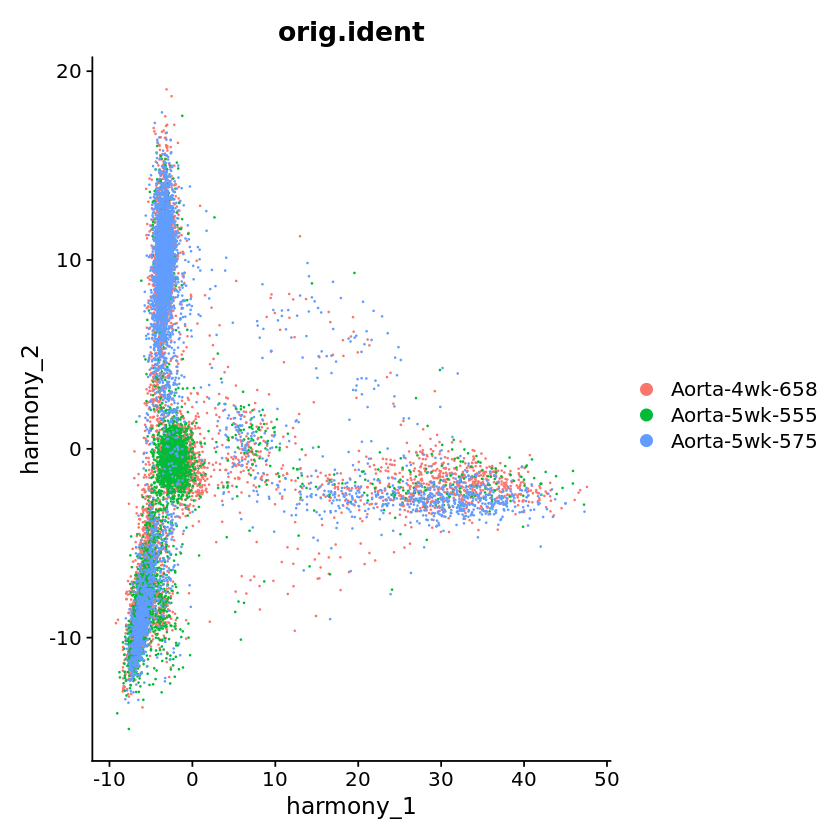

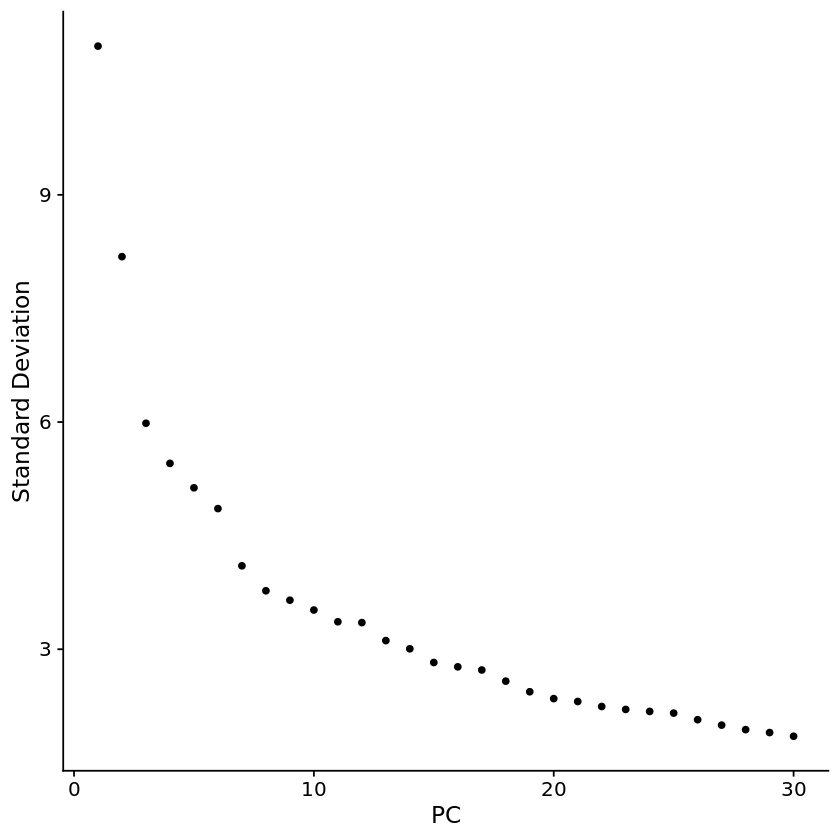

In [7]:
# run pca and harmony
sample <- RunPCA(sample, verbose = FALSE)
sample <- RunHarmony(sample, group.by.vars = "orig.ident", verbose = FALSE)
DimPlot(sample, reduction = "harmony", pt.size = 0.1, group.by = "orig.ident")
ElbowPlot(sample, ndims = 30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


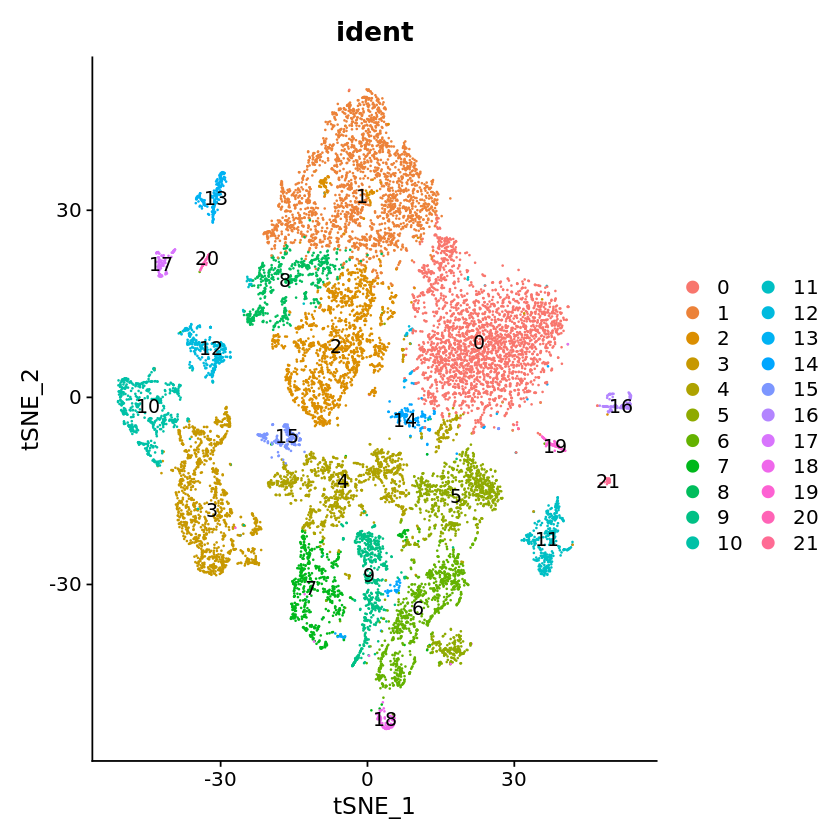

In [8]:
# dimension reduction and clustering
pca_dims <- 1:25
sample <- RunTSNE(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- RunUMAP(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindNeighbors(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindClusters(sample, resolution = 0.5, verbose = FALSE)
DimPlot(sample, label=TRUE, reduction = "tsne", group.by = "ident", pt.size = 0.1)

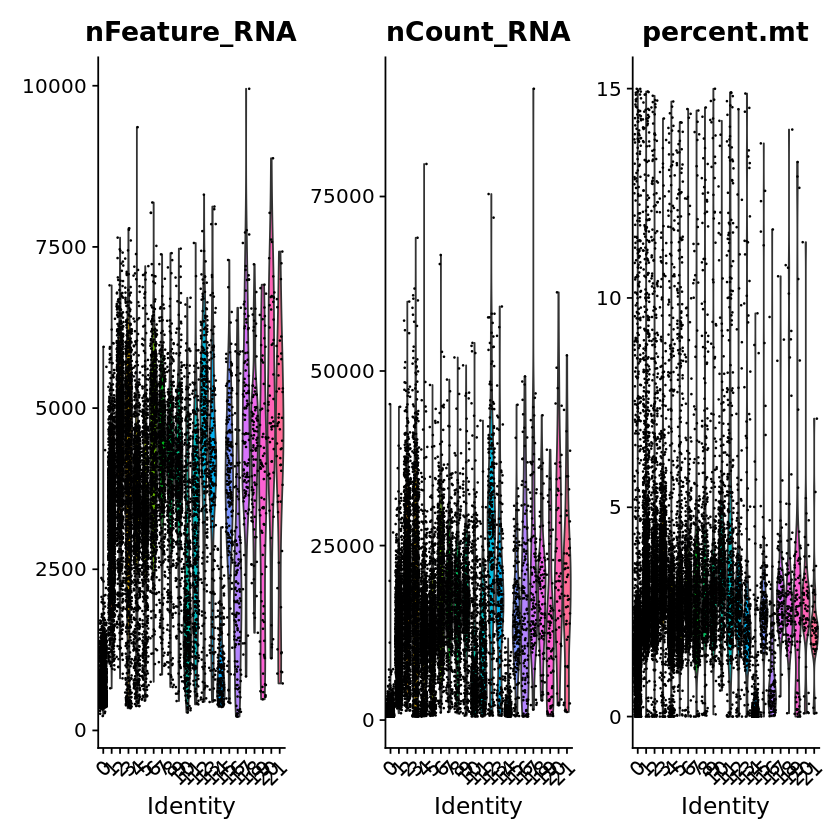

In [9]:
# count mito genes and make plots
VlnPlot(sample, features = c("nFeature_RNA","nCount_RNA","percent.mt"), group.by = "seurat_clusters", ncol = 3, pt.size = 0.1)
ggsave("figure/quality_control_human_AGM.pdf", width = 20, height = 8)

In [10]:
# remove low quality cell clusters
sample <- subset(sample, idents = c(0, 14), invert = T)
sample

An object of class Seurat 
36601 features across 11475 samples within 1 assay 
Active assay: RNA (36601 features, 2000 variable features)
 4 dimensional reductions calculated: pca, harmony, tsne, umap

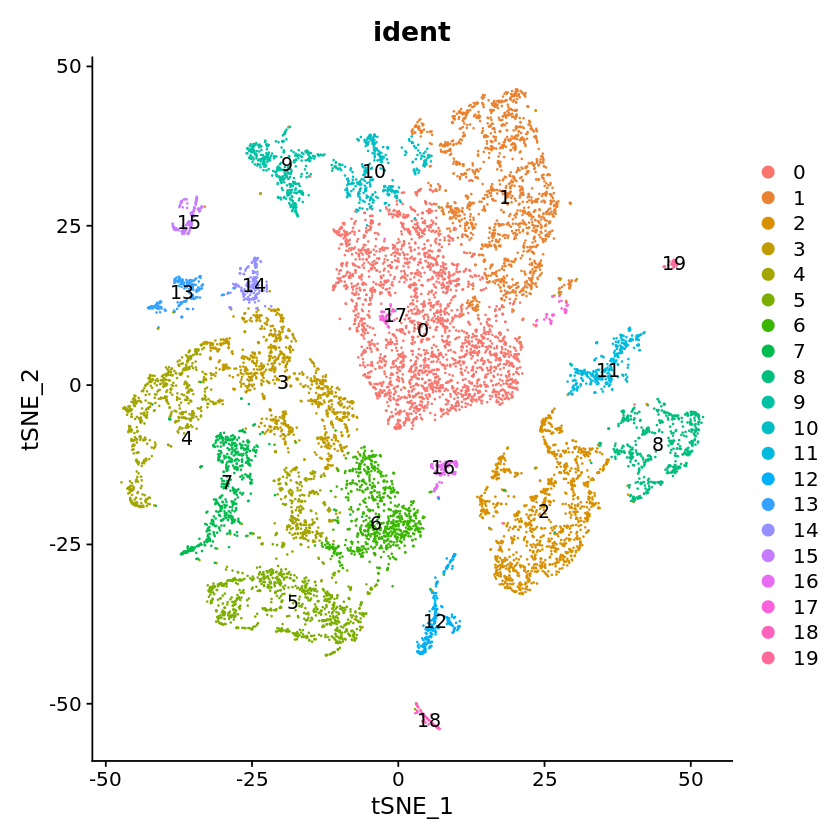

In [11]:
# dimension reduction and clustering
pca_dims <- 1:25
sample <- RunTSNE(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- RunUMAP(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindNeighbors(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindClusters(sample, resolution = 0.5, verbose = FALSE)
DimPlot(sample, label = TRUE, reduction = "tsne", group.by = "ident", pt.size = 0.1)

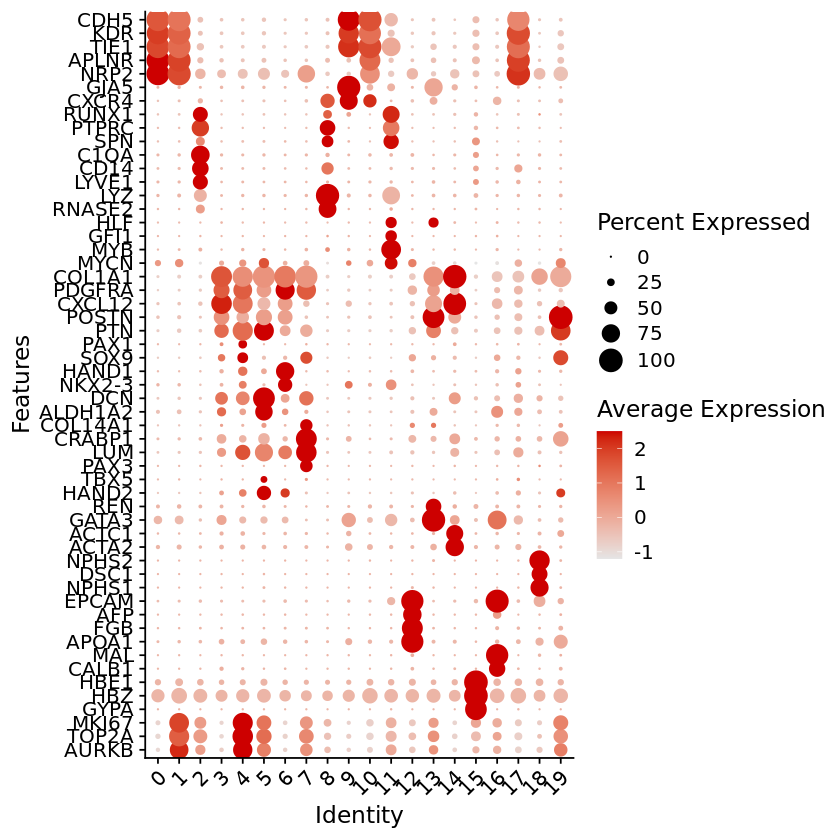

In [12]:
# all cell marker expression
Cell_identity_AGM <- c("CDH5","KDR","TIE1","APLNR","NRP2","GJA5","CXCR4",
               "RUNX1","PTPRC","SPN",
               "C1QA","CD14","LYVE1","LYZ","RNASE2",
               "HLF","GFI1","MYB","MYCN",
               "COL1A1","PDGFRA","CXCL12","POSTN","PTN","PAX1","SOX9","HAND1","NKX2-3","DCN","ALDH1A2","COL14A1","CRABP1","LUM","PAX3","TBX5","HAND2","REN","GATA3","ACTC1","ACTA2","NPHS2","DSC1","NPHS1",
               "EPCAM","AFP","FGB","APOA1","MAL","CALB1",
               "HBE1","HBZ","GYPA",
               "MKI67","TOP2A","AURKB")
DotPlot(sample, features = rev(Cell_identity_AGM), cols = c("grey90","red3"), group.by = "seurat_clusters") + coord_flip() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
#ggsave("figure/cell_identity_human_AGM.pdf", width = 9, height = 16)

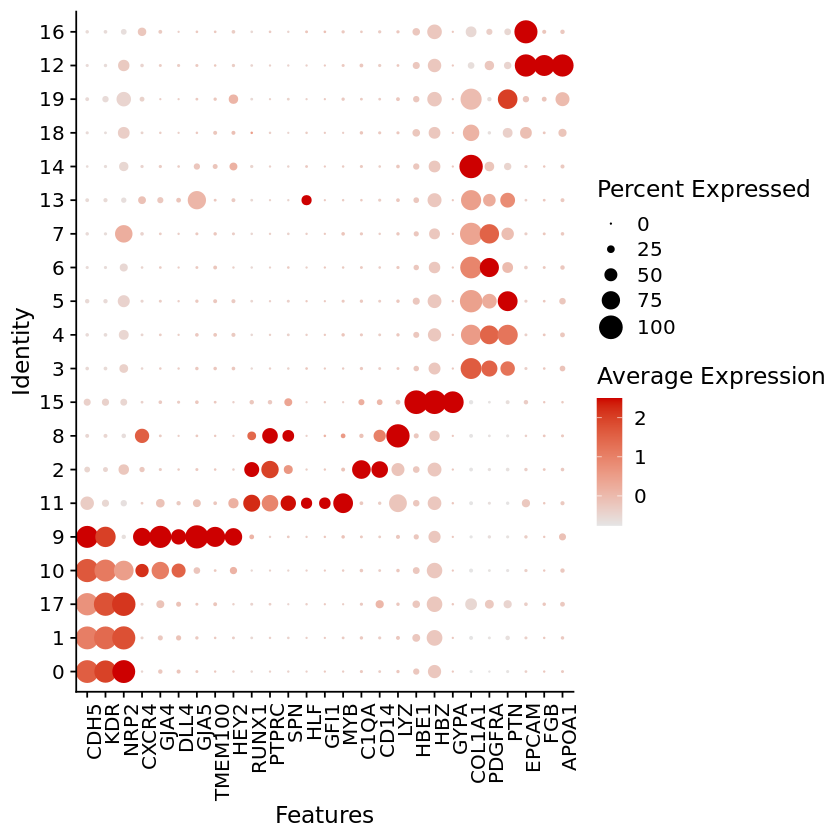

In [13]:
# AGM celltype signatures
Cell_identity_AGM <- c("CDH5","KDR","NRP2", # pan-endo
                       "CXCR4","GJA4","DLL4","GJA5","TMEM100","HEY2", # AEC, pre-HEC
                       "RUNX1","PTPRC","SPN", # pan-hema
                       "HLF","GFI1","MYB", # HSC
                       "C1QA","CD14","LYZ", # Hema progenitor
                       "HBE1","HBZ","GYPA", # Ery
                       "COL1A1","PDGFRA","PTN", # Stroma
                       "EPCAM","FGB","APOA1" # Epith
                )
sample$seurat_clusters <- factor(sample$seurat_clusters, levels = c(0,1,17,10,9,11,2,8,15,3,4,5,6,7,13,14,18,19,12,16))
DotPlot(sample, features = Cell_identity_AGM, cols = c("grey90","red3"), group.by = "seurat_clusters") + theme(axis.text.x = element_text(angle = 90, hjust = 1))
ggsave("figure/cluster_signature_human_AGM.pdf", width = 8.5, height = 5.5)

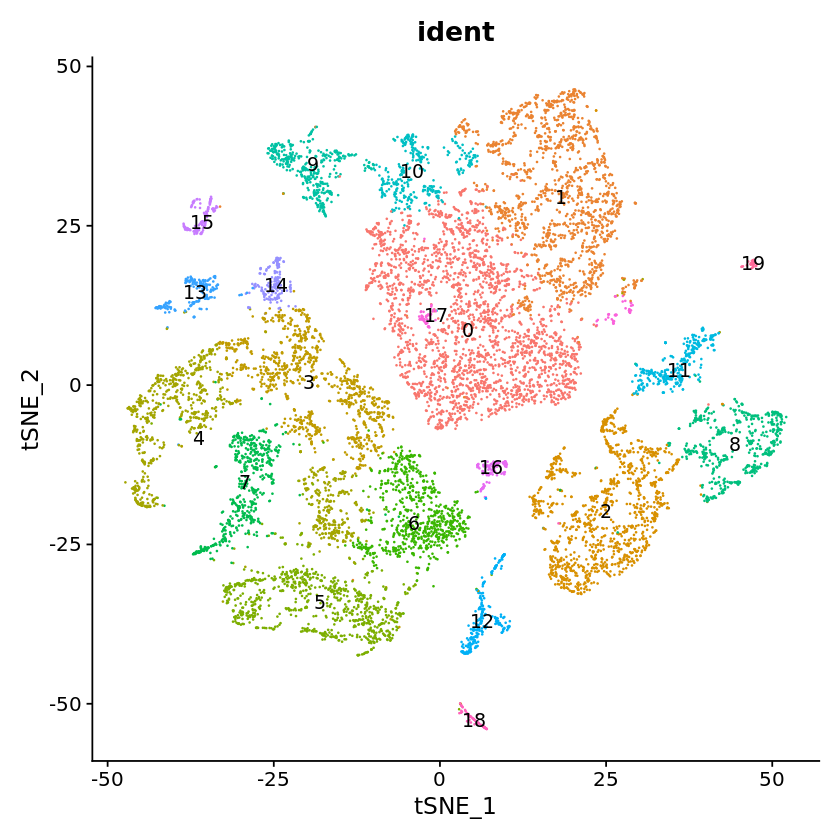

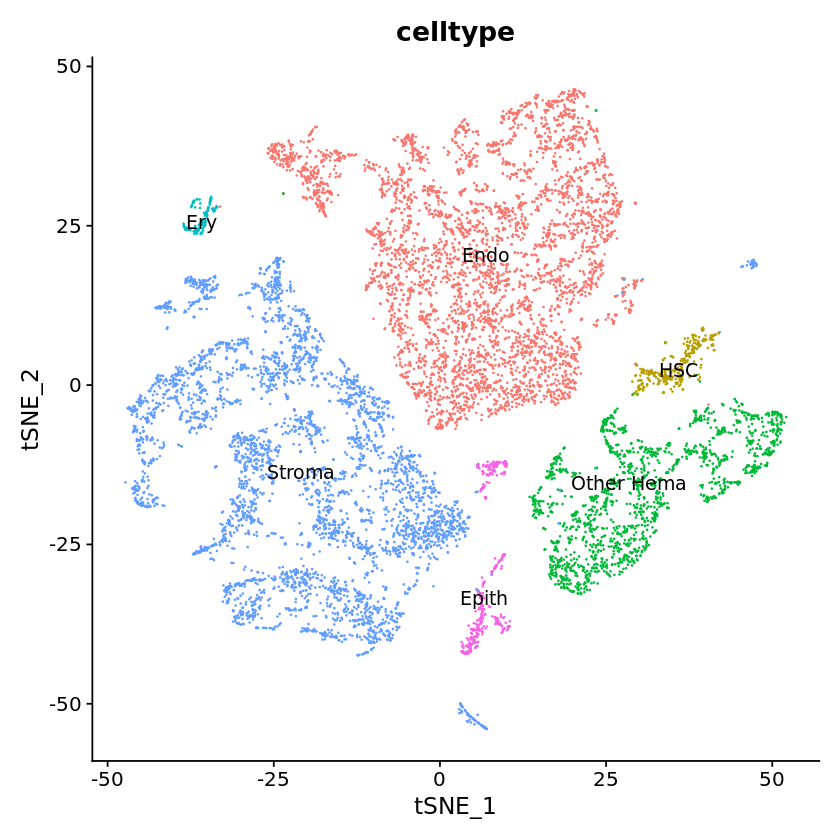

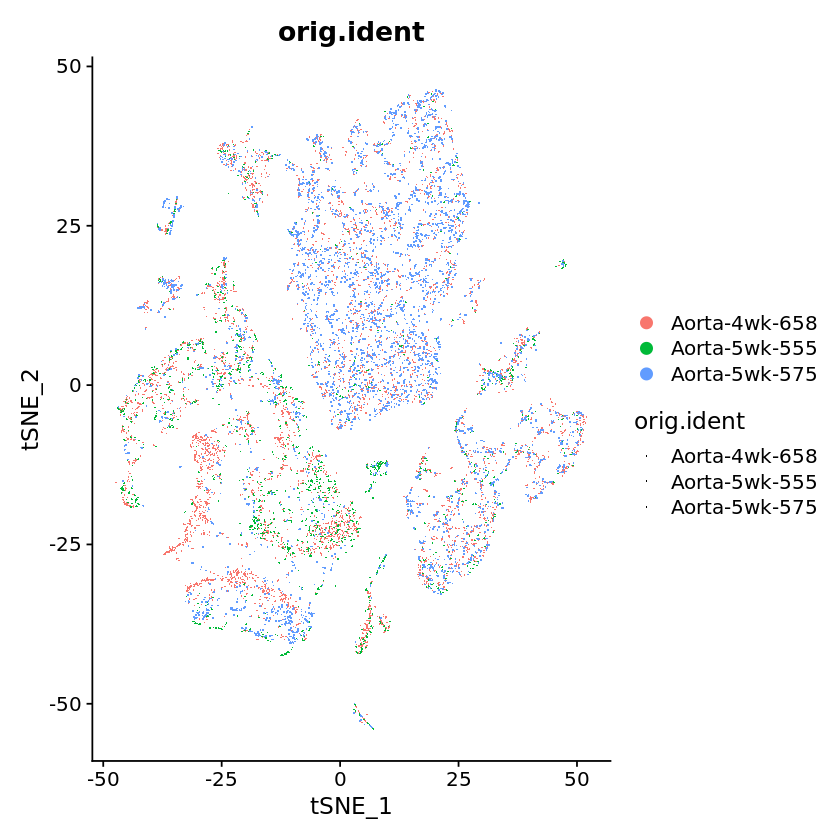

In [14]:
# AGM celltype annotation
cluster <- c(0:19)
celltype <- c("Endo","Endo","Other Hema","Stroma","Stroma","Stroma","Stroma","Stroma","Other Hema","Endo","Endo","HSC","Epith","Stroma","Stroma","Ery","Epith", "Endo","Stroma","Stroma")
sample$celltype <- plyr::mapvalues(Idents(sample), from = cluster, to = celltype)
sample$celltype <- factor(sample$celltype, levels = c("Endo","HSC","Other Hema","Ery","Stroma","Epith"))

DimPlot(sample, label = TRUE, reduction = "tsne", group.by = "ident", pt.size = 0.1) + theme(legend.position="none")
ggsave("figure/tsne_by_cluster_human_AGM.pdf", width = 5, height = 5)
DimPlot(sample, label=TRUE, reduction = "tsne", group.by = "celltype", pt.size = 0.1) + theme(legend.position="none")
ggsave("figure/tsne_by_celltype_human_AGM.pdf", width = 5, height = 5)
DimPlot(sample, label=FALSE, reduction = "tsne", group.by = "orig.ident", pt.size = 0.1, shape.by = "orig.ident")
ggsave("figure/tsne_by_sample_human_AGM.pdf", width = 6, height = 5)

In [15]:
# save the agm data
# saveRDS(sample, "sample_human_agm_annotated.rds")

In [16]:
# select Endo and HSC
sample <- subset(sample, cells = rownames(sample@meta.data[sample$celltype %in% c("Endo", "HSC"), ]))
sample

An object of class Seurat 
36601 features across 4920 samples within 1 assay 
Active assay: RNA (36601 features, 2000 variable features)
 4 dimensional reductions calculated: pca, harmony, tsne, umap

In [17]:
# normalize data by sctransform
sample <- SCTransform(sample, method = "glmGamPoi", verbose = FALSE)
sample

An object of class Seurat 
57127 features across 4920 samples within 2 assays 
Active assay: SCT (20526 features, 3000 variable features)
 1 other assay present: RNA
 4 dimensional reductions calculated: pca, harmony, tsne, umap

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.SCT.harmony; see ?make.names for more details on syntax validity”


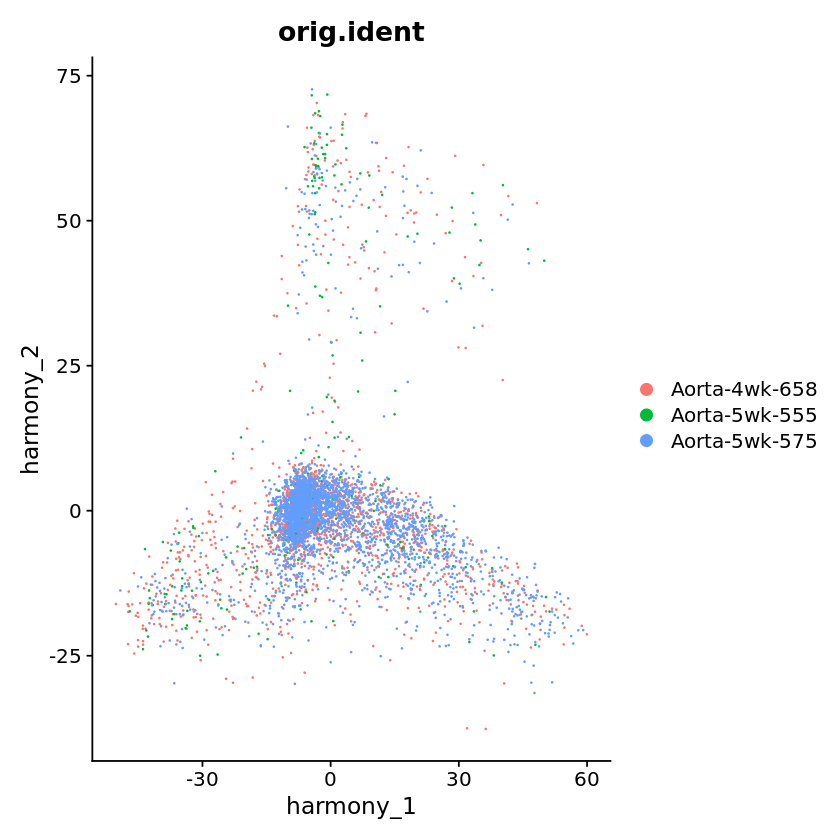

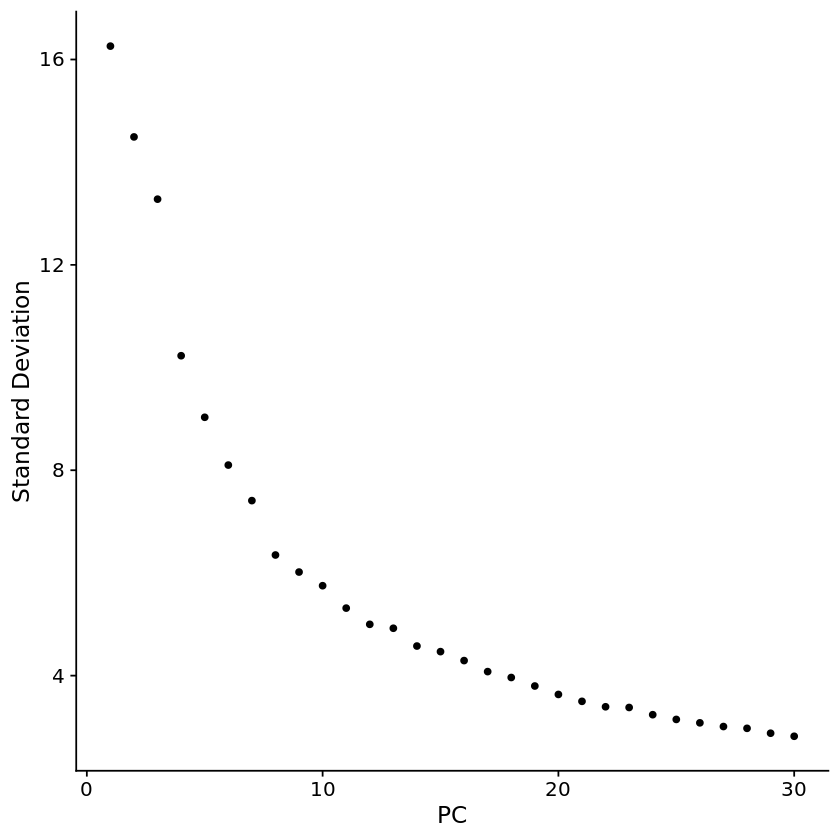

In [18]:
# run pca and harmony
sample <- RunPCA(sample, verbose = FALSE)
sample <- RunHarmony(sample, "orig.ident", verbose = FALSE)
DimPlot(sample, reduction = "harmony", pt.size = 0.1, group.by = "orig.ident")
ElbowPlot(sample, ndims = 30)

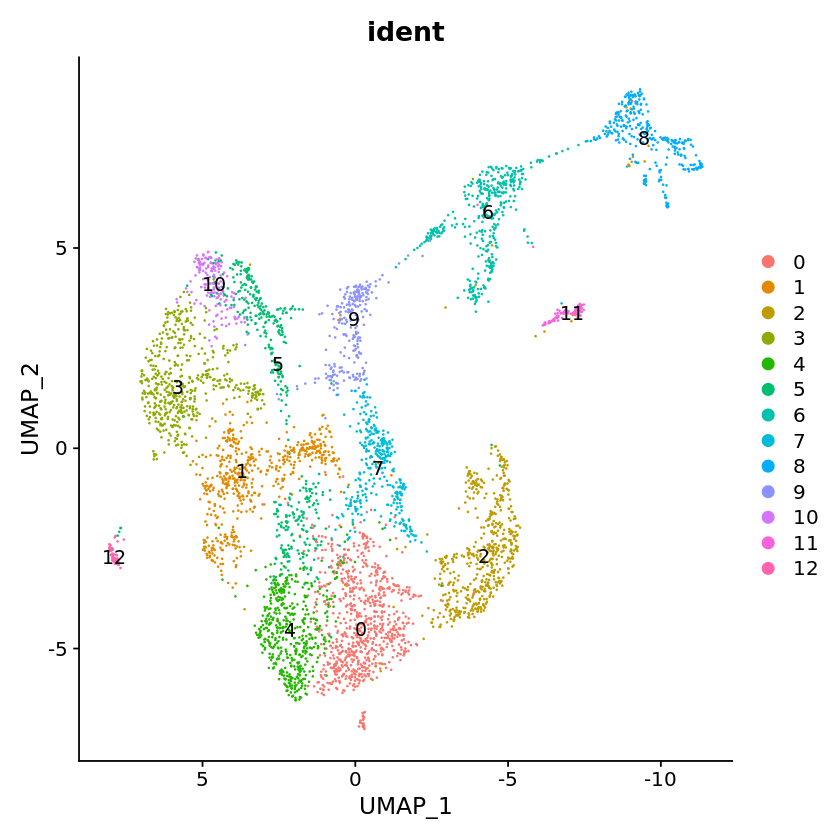

In [19]:
# dimension reduction and clustering
pca_dims <- 1:30
sample <- RunTSNE(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- RunUMAP(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindNeighbors(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindClusters(sample, resolution = 0.5, verbose = FALSE)
DimPlot(sample, label = TRUE, reduction = "umap", group.by = "ident", pt.size = 0.1) + scale_x_reverse()

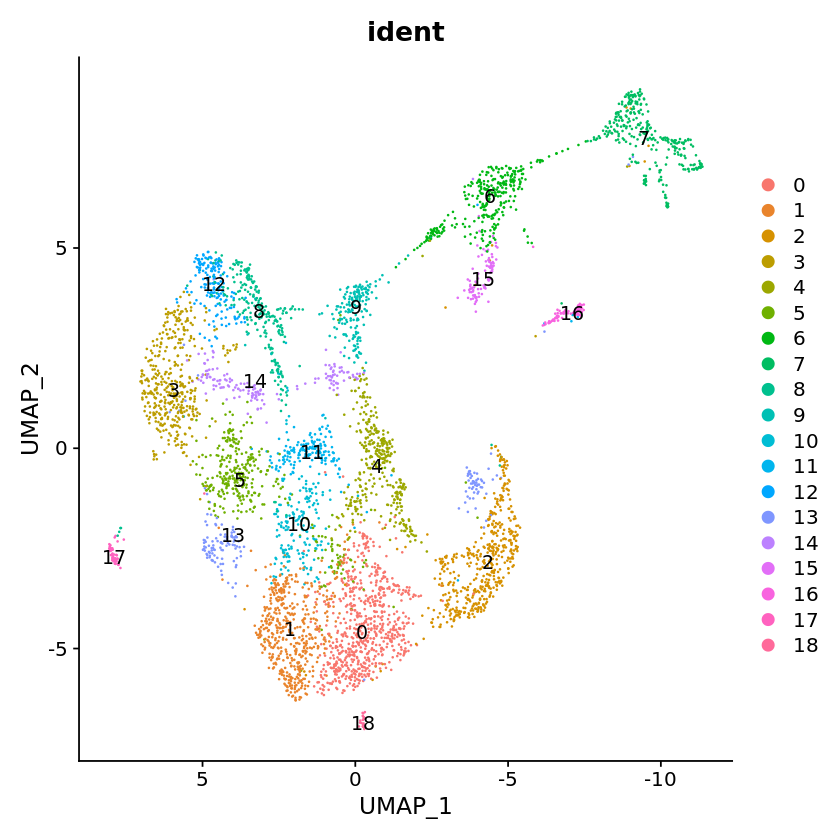

In [20]:
# add resolution
sample <- FindClusters(sample, resolution = 1.2, verbose = FALSE)
DimPlot(sample, label = TRUE, reduction = "umap", group.by = "ident", pt.size = 0.1) + scale_x_reverse()

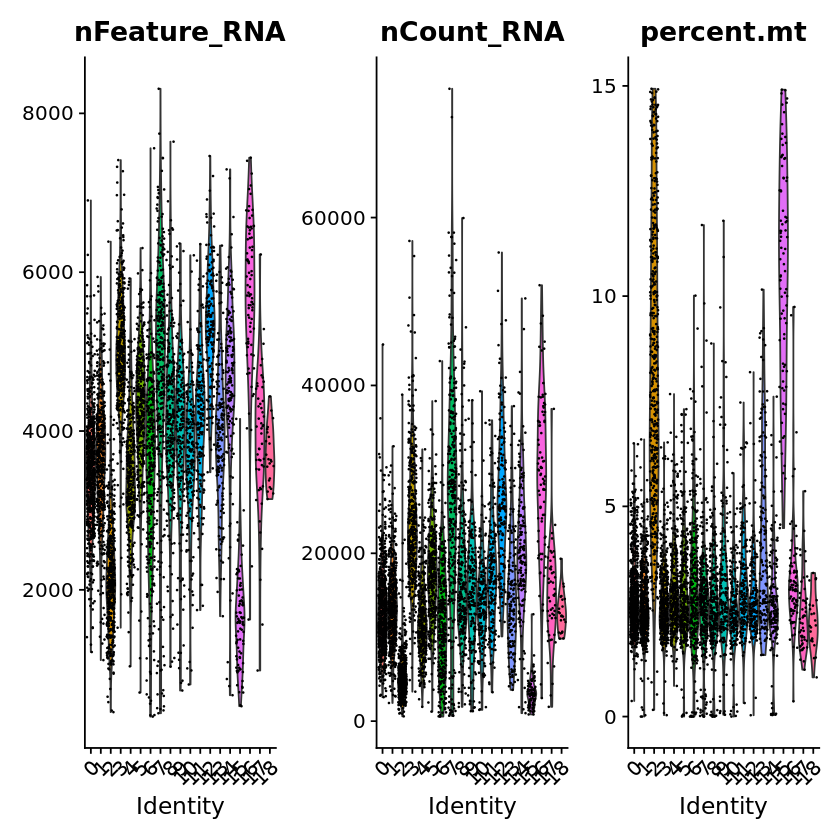

In [21]:
# quality control for clusters
VlnPlot(sample, features = c("nFeature_RNA","nCount_RNA","percent.mt"), group.by = "seurat_clusters", ncol = 3, pt.size = 0.1)
ggsave("figure/quality_control_human_EHT.pdf", width = 20, height = 8)

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


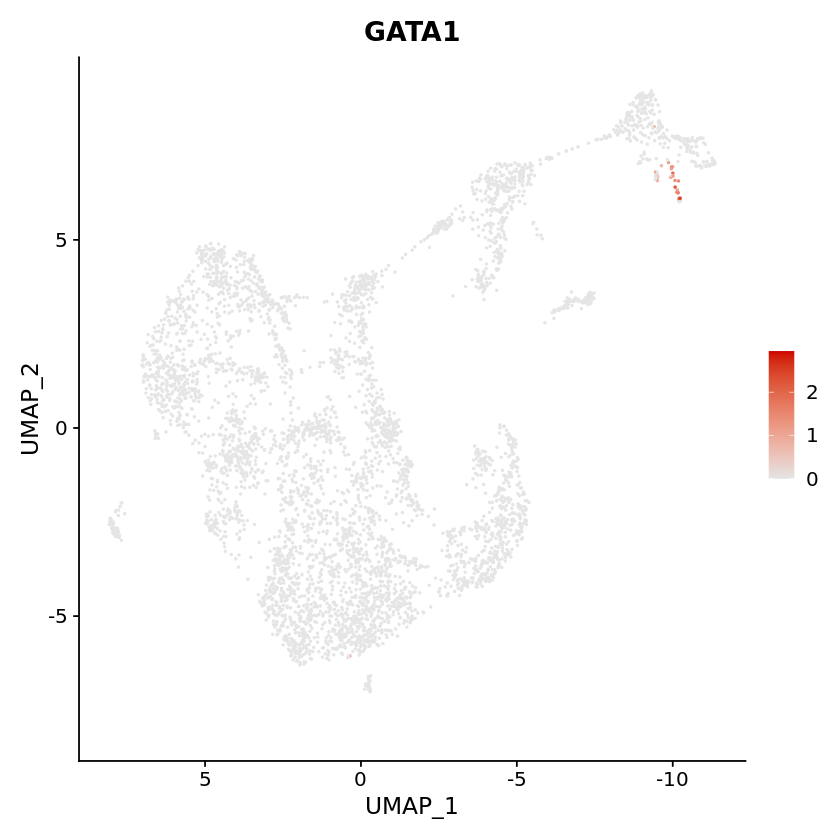

In [22]:
# GATA1+ in HSC
FeaturePlot(sample, features=c("GATA1"), cols=c("grey90","red3"), reduction="umap", min.cutoff = 0, keep.scale = "all") + scale_x_reverse()

In [23]:
# remove single clusters with very few cells, remove GATA1+ cells
sample <- subset(sample, idents = c(2, 15, 16, 17, 18), invert = T)
sample <- subset(sample, idents = 7, GATA1 > 0, invert = T)
sample

An object of class Seurat 
57127 features across 4158 samples within 2 assays 
Active assay: SCT (20526 features, 3000 variable features)
 1 other assay present: RNA
 4 dimensional reductions calculated: pca, harmony, tsne, umap

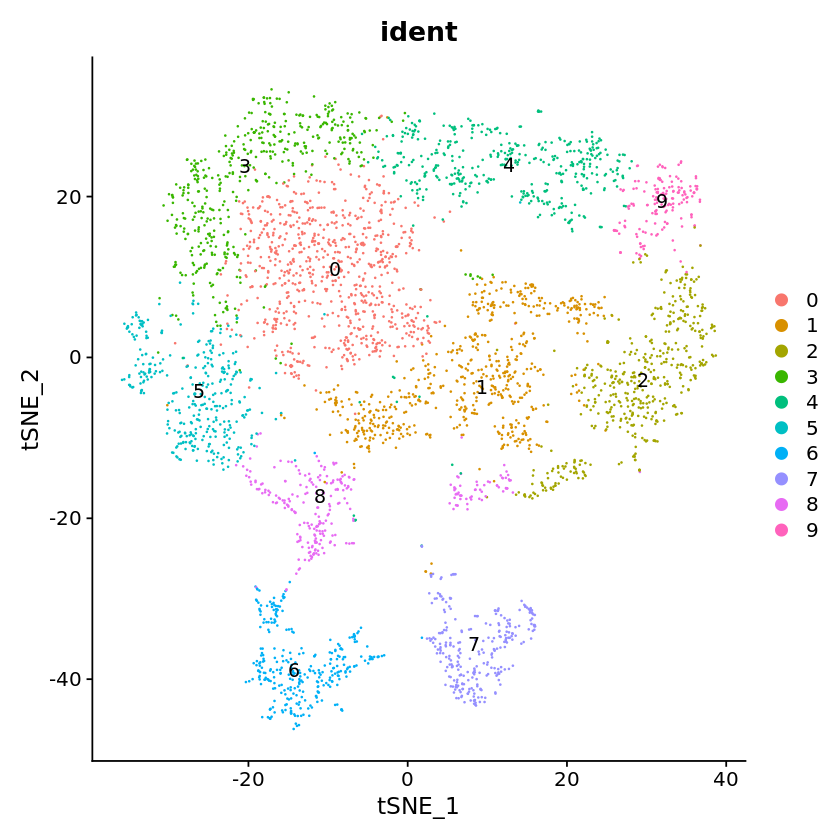

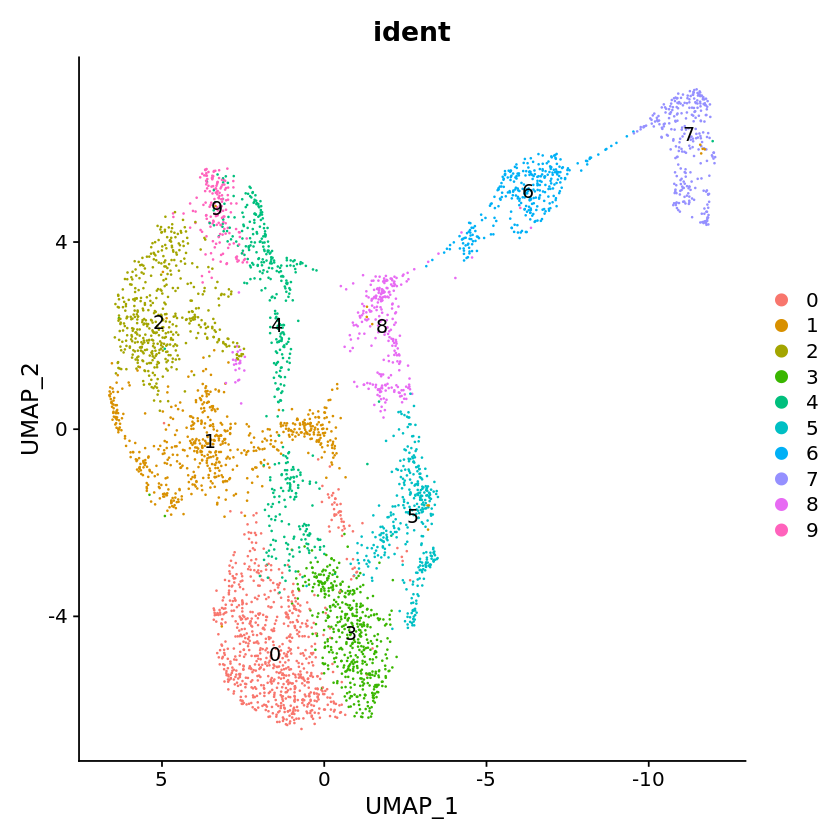

In [24]:
# dimension reduction and clustering
pca_dims <- 1:30
sample <- RunTSNE(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- RunUMAP(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindNeighbors(sample, dims = pca_dims, reduction = "harmony", verbose = FALSE)
sample <- FindClusters(sample, resolution = 0.5, verbose = FALSE)
DimPlot(sample, label = TRUE, reduction = "tsne", group.by = "ident", pt.size = 0.1)
DimPlot(sample, label = TRUE, reduction = "umap", group.by = "ident", pt.size = 0.1) + scale_x_reverse()

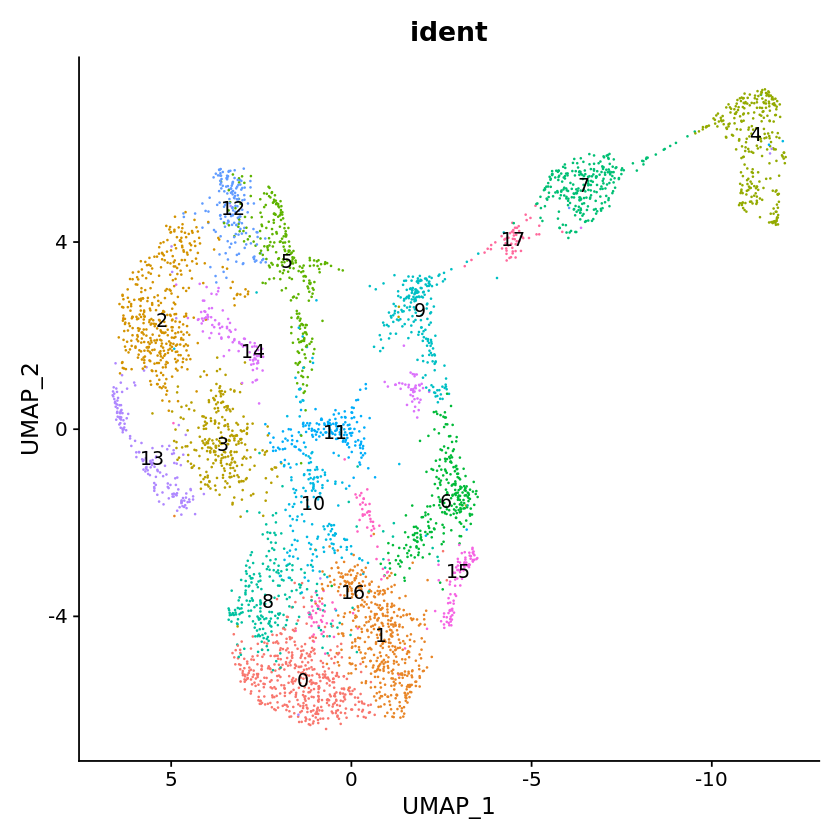

In [25]:
# add resolution
sample <- FindClusters(sample, resolution = 1.5, verbose = FALSE)
DimPlot(sample, label = TRUE, reduction = "umap", group.by = "ident", pt.size = 0.1) + scale_x_reverse() + theme(legend.position="none")
ggsave("figure/umap_by_cluster_human_EHT.pdf", width = 5, height = 5)

In [26]:
# save the unannotated object
#saveRDS(sample, file = "sample_human_unannotated.rds")
sample <- readRDS("sample_human_unannotated.rds")

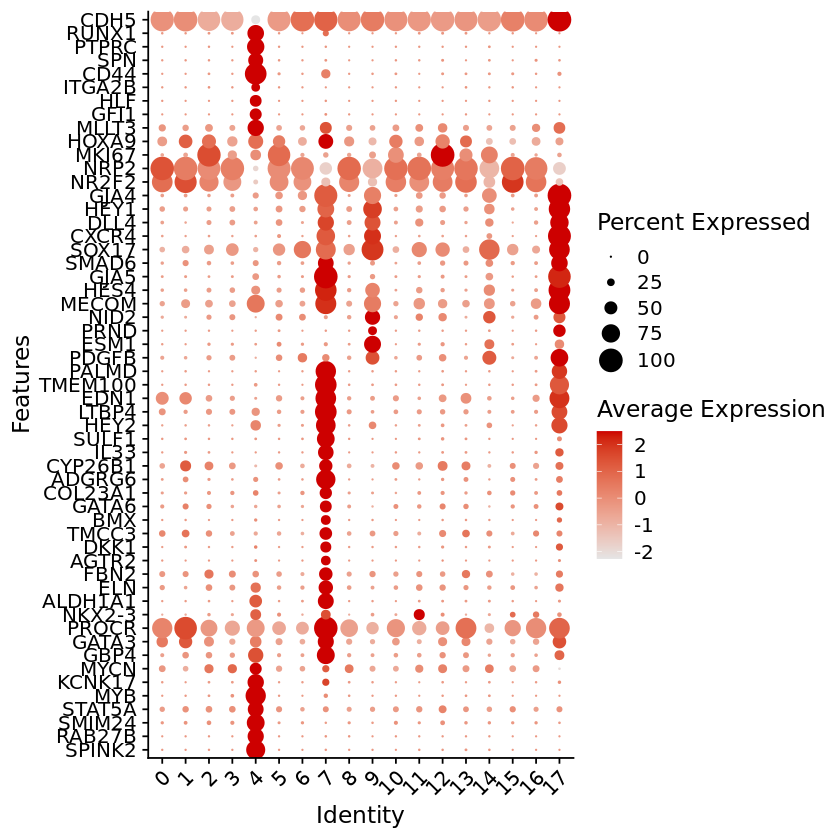

In [27]:
# all EHT markers expression
EHT_scorecard <- c("CDH5","RUNX1","PTPRC", "SPN","CD44","ITGA2B","HLF","GFI1","MLLT3","HOXA9","MKI67",
                 "NRP2","NR2F2",
                 "GJA4","HEY1","DLL4","CXCR4","SOX17","SMAD6","GJA5","HES4","MECOM",
                 "NID2","PRND","ESM1","PDGFB",
                 "PALMD","TMEM100","EDN1","LTBP4","HEY2",
                 "SULF1","IL33","CYP26B1",
                 "ADGRG6","COL23A1","GATA6","BMX","TMCC3","DKK1","AGTR2",
                 "FBN2","ELN","ALDH1A1","NKX2-3","PROCR","GATA3","GBP4",
                 "MYCN","KCNK17",
                 "MYB","STAT5A","SMIM24","RAB27B","SPINK2")
DotPlot(sample, features = rev(EHT_scorecard), cols=c("grey90","red3"), group.by="seurat_clusters") + coord_flip() + theme(axis.text.x=element_text(angle=45, hjust=1))
ggsave("figure/cell_identity_human_EHT.pdf", width = 12, height = 16)

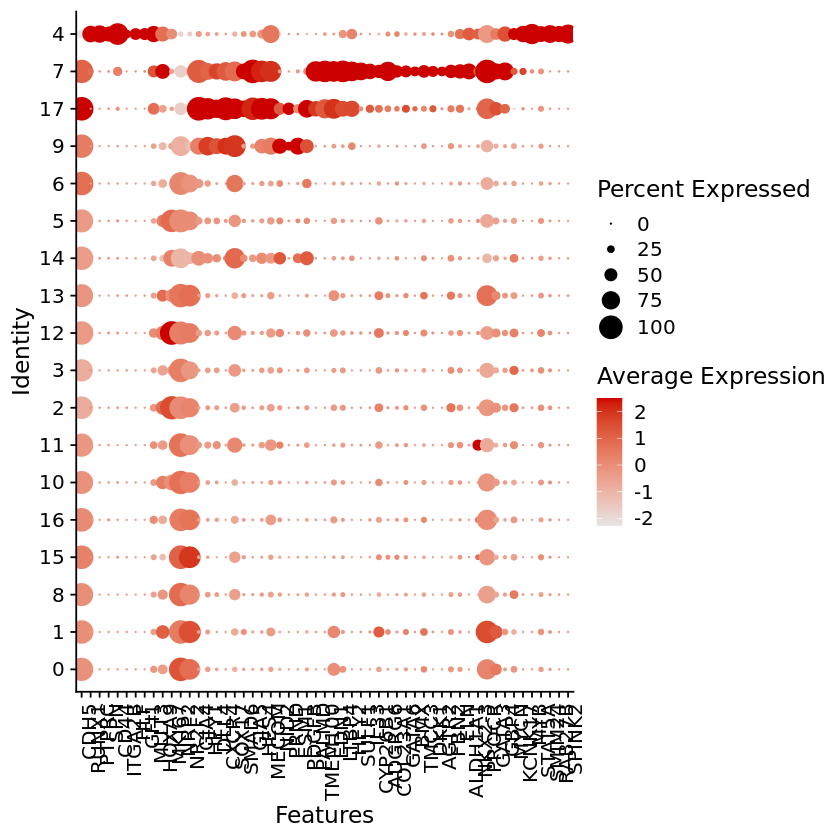

In [28]:
# EHT signature expression
EHT_scorecard <- c("CDH5","RUNX1","PTPRC","SPN","CD44","ITGA2B","HLF","GFI1","MLLT3","HOXA9","MKI67", # Landmarks
                 "NRP2","NR2F2", # VEC
                 "GJA4","HEY1","DLL4","CXCR4","SOX17","SMAD6","GJA5","HES4","MECOM", # AEC
                 "NID2","PRND","ESM1","PDGFB", # AEC enriched
                 "PALMD","TMEM100","EDN1","LTBP4","HEY2","SULF1","IL33","CYP26B1", # pre-HEC
                 "ADGRG6","COL23A1","GATA6","BMX","TMCC3","DKK1","AGTR2", # pre-HEC and HEC
                 "FBN2","ELN","ALDH1A1","NKX2-3","PROCR","GATA3","GBP4", # pre-HEC, HEC and HSC
                 "MYCN","KCNK17", # HE and HSC
                 "MYB","STAT5A","SMIM24","RAB27B","SPINK2") # HSC
sample$seurat_clusters <- factor(sample$seurat_clusters, levels = c(0,1,8,15,16,10,11,2,3,12,13,14,5,6,9,17,7,4))
DotPlot(sample, features = EHT_scorecard, cols=c("grey90","red3"), group.by="seurat_clusters") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/cluster_signature_human_EHT.pdf", width = 14, height = 6)

In [29]:
# EHT celltype annotation
cluster <- c(0:17)
celltype <- c("VEC","VEC","VEC","VEC","HSC","VEC","VEC","pre-HEC","VEC","AEC","VEC","VEC","VEC","VEC","VEC","VEC","VEC","AEC")
sample$celltype <- plyr::mapvalues(Idents(sample), from = cluster, to = celltype)

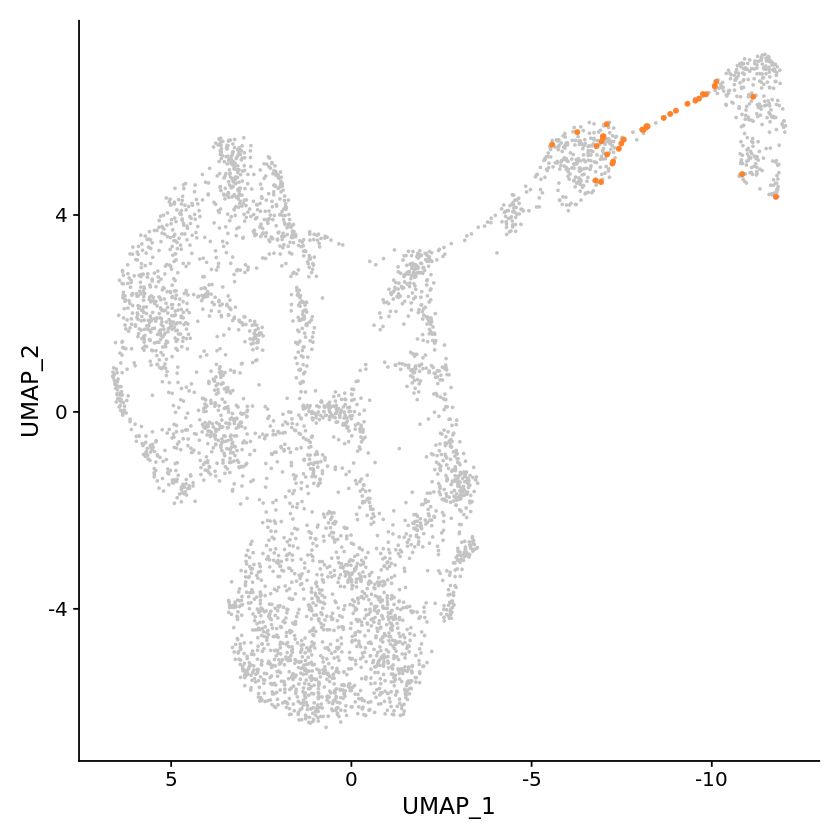

In [30]:
# HEC identification
sample$celltype <- as.character(sample$celltype)
sample@meta.data[colnames(subset(sample, idents = c(4, 7), CDH5>0 & RUNX1>0 & MYCN>0 & PTPRC==0)), ]$celltype <- "HEC"
DimPlot(sample, label=F, reduction = "umap", cells.highlight = colnames(subset(sample, idents = c(4, 7), CDH5>0 & RUNX1>0 & MYCN>0 & PTPRC==0)), cols.highlight = "#FF8228") + scale_x_reverse() + theme(legend.position="none")
ggsave("figure/umap_HEC_human_EHT.pdf", width = 5, height = 5)

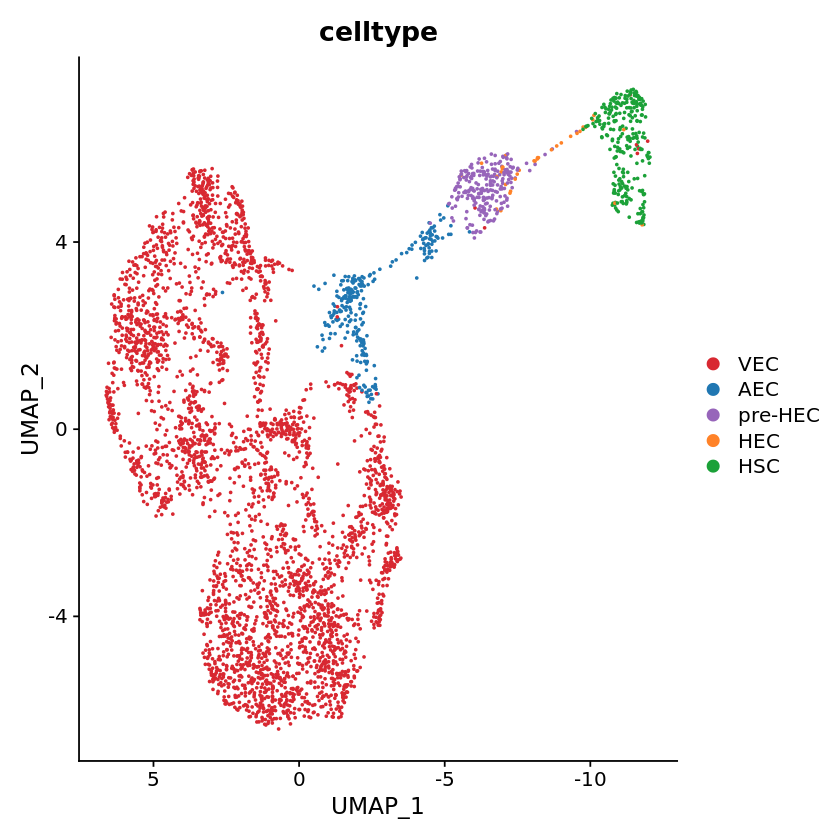

In [31]:
# draw the celltype umap
sample$celltype <- as.character(sample$celltype)
sample$celltype <- factor(sample$celltype, levels = c("VEC", "AEC", "pre-HEC", "HEC", "HSC"))
celltype_col <- c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138")
DimPlot(sample, label=F, reduction = "umap", cols = celltype_col, group.by = "celltype") + scale_x_reverse()
ggsave("figure/umap_by_celltype_human_EHT.pdf", width = 6, height = 5)

In [32]:
# calculate celltype markers
Idents(sample) <- sample$celltype
celltype_marker_genes <- FindAllMarkers(sample, assay = "RNA", test.use = "MAST", only.pos = TRUE, min.diff.pct = 0.1, verbose = FALSE)
sample@misc$celltype_marker_genes <- celltype_marker_genes
write.csv(celltype_marker_genes, "meta/celltype_markers_MAST_human.csv")


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [33]:
# save the annotated object
# saveRDS(sample, "sample_human_annotated.rds")

In [34]:
# generate meta info for velocity analysis
sample$obs_name <- paste(gsub(sample$orig.ident, pattern = "Aorta-5wk-575", replacement = "Aorta-5wks-575"), paste(unlist(strsplit(rownames(sample@meta.data), split = "-"))[seq(1, 2*nrow(sample@meta.data), by = 2)], "x", sep = ""), sep = ":")

write.csv(sample$obs_name, file = "meta/cellID_obs.csv", row.names = FALSE)

cell_embeddings <- Embeddings(sample, reduction = "umap")
rownames(cell_embeddings) <- sample$obs_name
write.csv(cell_embeddings, file = "meta/cell_embeddings.csv")

write.csv(data.frame(x = sample@meta.data$celltype, row.names = sample$obs_name), file = "meta/clusters.csv")

In [35]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggrepel_0.9.3      RColorBrewer_1.1-3 Hmisc_5.0-1        Matrix_1.5-4      
 [5] dplyr_1.1.1        ggplot2_3.4.2      harmony_0.1.1      Rcpp_1.0.10       
 [9] SeuratObject_4.1.3 Seurat_4.3.0      

loaded via a namespace (and not attached):
  [1] uuid_1.1-0                  backports_1.4.1            
  [3] systemfonts_1.0.4           plyr_1.8.8                 
  [5] igraph_1.4.2                repr_1.1.6